In [9]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.collections import PolyCollection
from matplotlib.ticker import FuncFormatter
import numpy as np
import matplotlib.patheffects as path_effects

def create_violin_plot(
    experiment_folder,
    eval_dict,
    metrics_to_plot,
    vlines,
    ylabels,
    legend_labels = None,
    yfiglabel = "",
    color_pair_size=2,
    skip_colors=0,
    bbox_to_anchor=(0.56, 1.175),
    font_config=None,
    use_hatching=True,
    hatch_style="//",
    save_figure_path = None,
    special_first_color = False,
    legend_title = None,
    title = None,
    title_x = 0.5,
    title_y = 1.0,
    color_violin = None,
    aspect = 0.8,
    height_inches = 4,
):
    # Update font configuration
    if font_config is None:
        font_config = {
            "font.size": 12,
            "axes.titlesize": 14,
            "axes.labelsize": 14,
            "xtick.labelsize": 10,
            "ytick.labelsize": 12,
            "legend.fontsize": 10,
            "legend.title_fontsize": 10,
        }
    plt.rcParams.update(font_config)

    # Load data
    data_dict = {label: pd.read_pickle(os.path.join(experiment_folder, path)) for label, path in eval_dict.items()}

    # Prepare plot data
    plot_data = pd.DataFrame([
        {'Dataset': label, 'Metric': metric_key, 'Value': val}
        for metric_key, _ in metrics_to_plot
        for label, data in data_dict.items()
        for val in data[metric_key].dropna()
    ])

    # Plot settings
    colors = sns.color_palette()[skip_colors:]
    if special_first_color:
        colors[0] = sns.color_palette()[0]
    if color_violin is None:
        dataset_colors = [colors[i // color_pair_size % len(colors)] for i in range(len(eval_dict.keys()))]
    else:
        color_map = {k:v for k,v in zip(['none', 'comp.', 'comp.+s.g.'], sns.color_palette()[:3])}
        dataset_colors = [color_map[color_violin]] * len(eval_dict.keys())
    # dataset_colors = [colors[i // color_pair_size % len(colors)] for i in range(len(eval_dict.keys()))]
    palette_dict = {label: dataset_colors[i] for i, label in enumerate(eval_dict.keys())}

    # height_inches = 1200 / 300
    # aspect = 0.8

    # Create the plot
    g = sns.catplot(
        data=plot_data,
        x="Value", y="Dataset", hue="Dataset", col="Metric",
        kind="violin", palette=palette_dict, cut=0, linewidth=1,
        inner=None, sharey=True, col_wrap=2, height=height_inches, aspect=aspect
    )

    # Add hatching, boxplots, and annotations
    for ax, (metric_key, metric_label) in zip(g.axes.flat, metrics_to_plot):
        metric_data = plot_data[plot_data["Metric"] == metric_key]
        sns.boxplot(
            data=metric_data, x="Value", y="Dataset", hue="Dataset", palette=palette_dict,
            ax=ax, fliersize=2, linewidth=0.5, whis=1.5, legend=False, boxprops=dict(alpha=0.2)
        )
        
        if use_hatching:
            for collection in ax.collections[::color_pair_size]:
                if isinstance(collection, PolyCollection):
                    collection.set_hatch(hatch_style)  # Apply hatching if enabled
        
        for i, label in enumerate(eval_dict):
            median_val = metric_data[metric_data["Dataset"] == label]["Value"].median()
            ax.text(
                median_val, i, f"{median_val:.2f}", ha="center", va="center", fontsize=10,
                color="black", path_effects=[path_effects.Stroke(linewidth=2, foreground="white"), path_effects.Normal()]
            )

        for vline in vlines:
            ax.axhline(vline + 0.5, color='gray', linestyle='--', linewidth=0.7)
        ax.set_xlabel(metric_label)
        ax.set_xlim(0, 3.0)
        ax.set_xticks(np.arange(0, 3.1, 1.0))
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.1f}"))
        ax.set_yticks(range(len(ylabels)))
        ax.set_yticklabels(ylabels)
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.5)
        ax.grid(True, which='both', axis='x', linestyle='--', linewidth=0.7, alpha=0.5)
        ax.set_ylabel(yfiglabel)
        ax.set_title("")

    if title is not None:
        g.fig.suptitle(title, x=title_x, y=title_y)
    if legend_labels is not None:
        handles = [Patch(color=palette_dict[label], label=label) for label in eval_dict.keys()][::color_pair_size][:len(legend_labels)]
        g.fig.legend(title=legend_title, handles=handles, labels=legend_labels, loc='upper center', ncol=len(legend_labels), bbox_to_anchor=bbox_to_anchor, frameon=True)
    g.fig.tight_layout()

    plt.show()
    if save_figure_path is not None:
        g.fig.savefig(save_figure_path, transparent=True, bbox_inches='tight', dpi=300)

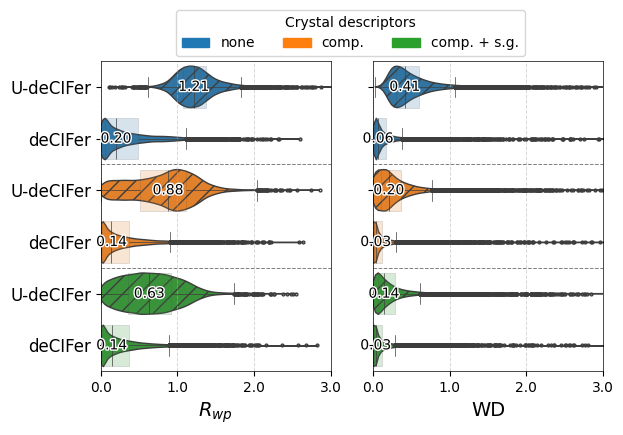

In [10]:
create_violin_plot(
    experiment_folder='../experiments/model__conditioned_mlp_augmentation__context_3076__robust/comparison_files_fullXRD__robust/',
    eval_dict={
        'U-deCIFer (none)': 'deCIFer-U_(None).pkl.gz',
        'deCIFer (none)': 'deCIFer_(None_N-0p00_B-0p05).pkl.gz',
        'U-deCIFer (comp.)': 'deCIFer-U_(Comp).pkl.gz',
        'deCIFer (comp.)': 'deCIFer_(Comp_N-0p00_B-0p05).pkl.gz',
        'U-deCIFer (comp. & s.g.)': 'deCIFer-U_(CompSG).pkl.gz',
        'deCIFer (comp. & s.g.)': 'deCIFer_(CompSG_N-0p00_B-0p05).pkl.gz',
    },
    metrics_to_plot=[('rwp', r"$R_{wp}$"), ('wd', "WD")],
    vlines=[1, 3],
    legend_labels=['none', 'comp.', 'comp. + s.g.'],
    ylabels=['U-deCIFer', 'deCIFer', 'U-deCIFer', 'deCIFer', 'U-deCIFer', 'deCIFer'],
    use_hatching=True,
    save_figure_path="baseline_violin_plot_metrics.pdf",
    legend_title="Crystal descriptors",
    bbox_to_anchor=(0.56, 1.1),
    # title = 'NOMA test set',
    title_x = 0.56,
    title_y = 1.1,
)

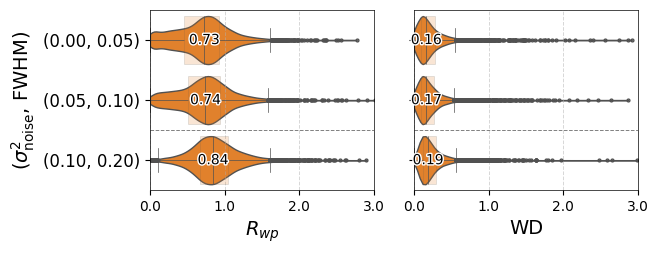

In [10]:
create_violin_plot(
    experiment_folder='../experiments/model__conditioned_mlp_augmentation__context_3076__robust/comparison_files_fullXRD__robust/',
    eval_dict={
        # 'U-deCIFer chili (comp)': 'deCIFer-U_chili_(None).pkl.gz',
        'deCIFer chili (compN0B5)': 'deCIFer_chili_dedup_(Comp_N-0p00_B-0p05).pkl.gz',
        'deCIFer chili (compN5B10)': 'deCIFer_chili_dedup_(Comp_N-0p05_B-0p10).pkl.gz',
        # 'deCIFer chili (compN10B5)': 'deCIFer_chili_(Comp_N-0p10_B-0p05).pkl.gz',
        # 'deCIFer chili (compN0B20)': 'deCIFer_chili_(Comp_N-0p00_B-0p20).pkl.gz',
        'deCIFer chili (compN10B20)': 'deCIFer_chili_dedup_(Comp_N-0p10_B-0p20).pkl.gz',
    },
    metrics_to_plot=[
        ('rwp', r"$R_{wp}$"),
        ('wd', "WD"),
    ],
    vlines=[1],
    ylabels=[
        # 'U-deCIFer',
        '(0.00, 0.05)', 
        '(0.05, 0.10)', 
        # '(0.10, 0.05)', 
        # '(0.00, 0.20)', 
        '(0.10, 0.20)',
    ],
    color_pair_size=1,
    skip_colors = 0,
    special_first_color = True,
    yfiglabel="($\sigma_{\mathrm{noise}}^2$, FWHM)",
    # legend_labels=['comp.'],
    legend_title="",
    bbox_to_anchor=(0.58, 1.1),
    save_figure_path="chili100k_violin_plot_metrics.pdf",
    use_hatching=False,
    # title = 'CHILI-100K 20k subsample',
    title_x = 0.56,
    title_y = 1.1,
    color_violin = 'comp.',
    height_inches=2.7,
    aspect = 1.25
)


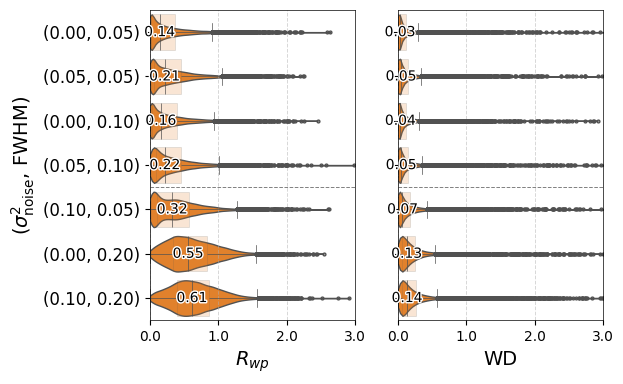

In [11]:
create_violin_plot(
    experiment_folder='../experiments/model__conditioned_mlp_augmentation__context_3076__robust/comparison_files_fullXRD__robust/',
    eval_dict={
        'deCIFer (compN0B5)': 'deCIFer_(Comp_N-0p00_B-0p05).pkl.gz',
        'deCIFer (compN5B5)': 'deCIFer_(Comp_N-0p05_B-0p05).pkl.gz',
        'deCIFer (compN0B10)': 'deCIFer_(Comp_N-0p00_B-0p10).pkl.gz',
        'deCIFer (compN5B10)': 'deCIFer_(Comp_N-0p05_B-0p10).pkl.gz',
        'deCIFer (compN10B5)': 'deCIFer_(Comp_N-0p10_B-0p05).pkl.gz',
        'deCIFer (compN0B20)': 'deCIFer_(Comp_N-0p00_B-0p20).pkl.gz',
        'deCIFer (compN10B20)': 'deCIFer_(Comp_N-0p10_B-0p20).pkl.gz',
    },
    metrics_to_plot=[
        ('rwp', r"$R_{wp}$"),
        ('wd', "WD"),
    ],
    vlines=[3],  # Single vertical line at index 3
    ylabels=[
        '(0.00, 0.05)', 
        '(0.05, 0.05)', 
        '(0.00, 0.10)', 
        '(0.05, 0.10)', 
        '(0.10, 0.05)', 
        '(0.00, 0.20)', 
        '(0.10, 0.20)', 
    ],
    color_pair_size=1, 
    skip_colors=3,
    use_hatching=False, 
    save_figure_path="robustness_violin_plot_metrics.pdf", 
    yfiglabel="($\sigma_{\mathrm{noise}}^2$, FWHM)",
    # legend_labels=['comp.'],
    legend_title="",
    bbox_to_anchor=(0.56, 1.1),
    # title = 'NOMA test set',
    title_x = 0.58,
    title_y = 1.1,
    color_violin = 'comp.',
)
